In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats import skew, kurtosis, zscore
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from scipy.fft import fft, fftfreq
from tqdm import tqdm
from pytz import timezone
import json

In [2]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']
SAMPLING_RATE = 1/60

In [3]:
DISCARD_VARIABLES = False # whether variables can be discarded
USE_IMPUTATION = False # whether feature vector should be built on imputed data or raw data
NORMALIZE_SUBJECTS = True # whether to normalize all variables subject-wise (to counteract high subject variability)

In [4]:
def get_time_series(dat, variable, day):
    entry = dat[variable][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
    return time_series

def plotter(day, dat):
    """
    Plots time-series of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def na_visualizer(days, dat):
    """
    Plots missing data for specific days in red/green
    """
    for day in days:
        length = get_time_series(dat, 'ActivityCounts', day).shape[0]
        n_variables = len(VARIABLES)
        na_matrix = np.zeros((n_variables, length))

        for i, variable in enumerate(VARIABLES):
            time_series = get_time_series(dat, variable, day)

            na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
            na_matrix[i, :] = na_data

        # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
        na_matrix[1, 1] = 0.0
        na_matrix[2, 1] = 1.0

        # plot
        cmap = matplotlib.colors.ListedColormap(['red', 'green'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    """
    Calculates lengths of missing data sequences of full dataset
    """
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

def imputer(dat, max_fill=50, method='linear'):
    """
    Imputes missing data for full dataset
    """
    dat2 = dat.copy()

    for variable in VARIABLES:
        time_series_all_days = []
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            time_series_all_days.append(time_series)

        pre_imputation = pd.DataFrame(time_series_all_days)
        post_imputation = pre_imputation.interpolate(method=method, axis=1, limit=max_fill, limit_direction='both')

        # update dataframe with imputation data
        for day in range(dat2.shape[0]):
            dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])

    return dat2

def missing_data_per_variable(dat):
    """
    Calculates missing data ratio for each variable
    """
    dat2 = dat.copy()

    missing_data_variable = {variable: [] for variable in VARIABLES}
    for variable in VARIABLES:
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            na_data = list(np.where(np.isnan(time_series), 0.0, 1.0)) # NaN -> 0, data -> 1
            missing_data_variable[variable] += na_data

    missing_data_variable = {variable: np.mean(na_data) for variable, na_data in missing_data_variable.items()}
    return missing_data_variable

def tz_diff(date, tz1, tz2):
    """
    Returns the difference in hours between timezone1 and timezone2
    for a given date.
    """
    tz1 = 'CET' if tz1 == 'CEST' else tz1 # CEST is just summertime CET
    tz2 = 'CET' if tz2 == 'CEST' else tz2 # CEST is just summertime CET

    date = pd.to_datetime(date)
    tz1, tz2 = timezone(tz1), timezone(tz2)
    return (tz1.localize(date) - tz2.localize(date).astimezone(tz1)).seconds / 3600

def peaks_fft(time_series):
    """Returns freqs, magnitude of peaks of positive FFT"""
    # remove NaNs
    time_series = time_series[~np.isnan(time_series)]

    # freq-domain
    fourier = fft(time_series, norm='forward') # TODO: forward normalizes - correct way?
    freqs = fftfreq(len(time_series), d=1/SAMPLING_RATE)
    magnitudes = np.abs(fourier)
    peaks_index, properties = find_peaks(magnitudes)

    # only positive freqs without DC component
    magnitudes_pos = magnitudes[0:(len(magnitudes) // 2)]
    freqs_pos = freqs[0:(len(freqs) // 2)]
    peaks_index_pos = [peak_i for peak_i in peaks_index if peak_i < len(magnitudes_pos)]

    return freqs_pos[peaks_index_pos], magnitudes_pos[peaks_index_pos]

def peaks_psd(time_series):
    """Returns freqs, magnitude of peaks of power spectral density"""
    # remove NaNs
    time_series = get_time_series(data, 'HRV', 49)
    time_series = time_series[~np.isnan(time_series)]

    # freq-domain
    freqs, psd = welch(time_series, fs=SAMPLING_RATE)
    peaks_index, properties = find_peaks(psd)

    return freqs[peaks_index], psd[peaks_index]

def feature_vector(dat):
    """Builds feature vector according to Novartis paper"""
    days, _ = dat.shape

    feature_vec = None
    for day in range(days):
        x = []
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)
            time_series = time_series[~np.isnan(time_series)] # remove NaN
            time_series += np.random.normal(1, 1e-12, len(time_series)) # noise for stability for spectral features

            if variable == 'ActivityClass':
                one_hot = [np.sum(time_series == 0.0),
                           np.sum(time_series == 1.0),
                           np.sum(time_series == 9.0),
                           np.sum(time_series == 10.0),
                           np.sum(time_series == 11.0),
                           np.sum(time_series == 12.0)]
                x += one_hot
            else:
                # time-domain features
                mean = np.mean(time_series)
                std = np.std(time_series)
                median = np.median(time_series)
                max = np.max(time_series)
                min = np.min(time_series)
                skewness = skew(time_series, axis=0, bias=True)
                kurtos = kurtosis(time_series, axis=0, bias=True)
                percentile_5 = np.percentile(time_series, 5, axis=0)
                percentile_95 = np.percentile(time_series, 95, axis=0)
                sum = [np.sum(time_series)] if variable in ('ActivityCounts', 'Steps', 'EnergyExpenditure') else []

                # spectral features
                # fourier
                freqs, magnitudes = peaks_fft(time_series)
                magnitudes_2_to_5 = magnitudes[:4] # 2nd - 5th peaks
                freqs_fft_2_to_5 = freqs[:4] # 2nd - 5th peaks
                # power spectral density
                freqs, psd = peaks_psd(time_series)
                psd_2_to_5 = psd[:4] # 2nd - 5th peaks
                freqs_psd_2_to_5 = freqs[:4] # 2nd - 5th peaks

                x += [mean, std, median, max, min, skewness, kurtos, percentile_5, percentile_95,
                      *sum, *magnitudes_2_to_5, *freqs_fft_2_to_5, *psd_2_to_5, *freqs_psd_2_to_5]

        #print(day, len(x), x, '\n\n')
        feature_vec = np.append(feature_vec, [np.array(x)], axis=0) if feature_vec is not None else np.array([x])

    return feature_vec

def label_vector(dat):
    """Builds label vector [phF, MF]"""
    days, _ = dat.shape

    y = []
    for day in range(days):
        y.append([dat['phF'].iloc[day], dat['MF'].iloc[day]]) # labels
    return np.array(y)

# Import data

In [5]:
# file path to data folder
path = './Output'

In [6]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

# Discarding data 1/2

Filter out variables from dataset

Text(0, 0.5, 'available data [%]')

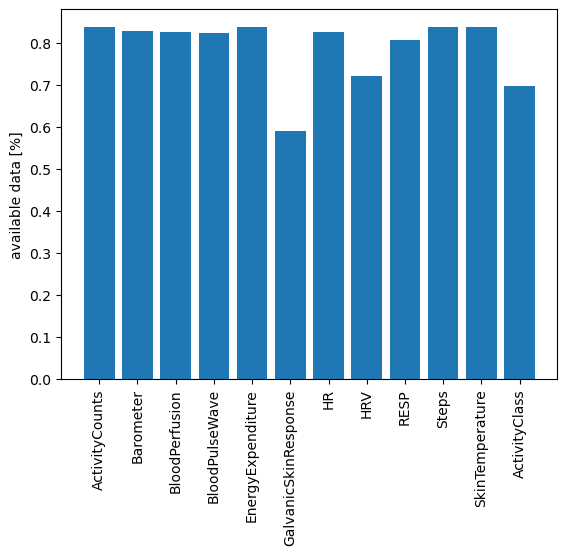

In [7]:
# missing data per variable
temp = missing_data_per_variable(data)

plt.bar(x=temp.keys(), height=temp.values())
plt.xticks(rotation=90)
plt.ylabel('available data [%]')

In [8]:
# discard variables from dataset (too much missing data)
if DISCARD_VARIABLES:
    to_discard = ['GalvanicSkinResponse', 'ActivityClass']

    data = data.drop(columns=to_discard)
    VARIABLES = [variable for variable in VARIABLES if variable not in to_discard]

Filter out days with sensors out all days

In [9]:
'''na_visualizer([0, 1, 2, 3, 4, 5, 6, 7, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 57, 59, 60, 61, 63, 68, 113, 114, 116, 117, 273, 380, 384, 389, 396, 398, 400, 405, 406, 408, 409], data)'''

'na_visualizer([0, 1, 2, 3, 4, 5, 6, 7, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 57, 59, 60, 61, 63, 68, 113, 114, 116, 117, 273, 380, 384, 389, 396, 398, 400, 405, 406, 408, 409], data)'

In [10]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        # if only missing data for full day -> discard day
        if np.sum(np.where(np.isnan(time_series), 0.0, 1.0)) == 0: # NaN -> 0, data -> 1
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (sensor out): {discarded_days} ({len(np.unique(discarded_days))})')
print(f'Days left: {len(data)}')

Discarded days (sensor out): [0, 1, 2, 3, 4, 5, 6, 7, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 57, 59, 60, 61, 63, 68, 113, 114, 116, 117, 273, 380, 384, 389, 396, 398, 400, 405, 406, 408, 409] (42)
Days left: 368


Filter out days with > 80% missing data

In [11]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        # if only missing data for full day -> discard day
        if np.sum(np.where(np.isnan(time_series), 0.0, 1.0)) < 0.2 * length: # NaN -> 0, data -> 1
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (sensor out): {discarded_days} ({len(np.unique(discarded_days))})')
print(f'Days left: {len(data)}')

Discarded days (sensor out): [11, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 23, 27, 28, 29, 31, 34, 36, 37, 38, 39, 41, 42, 43, 44, 60, 65, 66, 67, 68, 73, 74, 74, 84, 84, 85, 85, 86, 86, 87, 89, 104, 107, 111, 112, 112, 187, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 321, 348, 349, 350, 355, 355, 356, 358, 359, 362, 363, 364, 365, 367] (50)
Days left: 318


Filter out days with data < 5min

In [12]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        if length < 5:
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (sensor out): {discarded_days} ({len(np.unique(discarded_days))})')
print(f'Days left: {len(data)}')

Discarded days (sensor out): [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245] (1)
Days left: 317


# Normalization

In [13]:
if NORMALIZE_SUBJECTS:
    # normalize each variable considering only subject data
    days, _ = data.shape
    for subject in np.unique(data['subjectID']):
        days_subj = np.arange(days)[data['subjectID'] == subject]

        for variable in [var for var in VARIABLES if var != 'ActivityClass']: # don't normalize categorical var.
            # get mean, variance of all subject data
            full_time_series = np.array([datapoint for day in days_subj for datapoint in get_time_series(data, variable, day)]).reshape(-1, 1)
            scaler = StandardScaler()
            scaler.fit(full_time_series)

            # normalize accordingly
            for day in days_subj:
                time_series = get_time_series(data, variable, day).reshape(-1, 1)
                data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)

else:
    # normalize each variable considering all subjects
    days, _ = data.shape
    for variable in [var for var in VARIABLES if var != 'ActivityClass']: # don't normalize categorical var.
        # get mean, variance of all subject data
        full_time_series = np.array([datapoint for day in range(days) for datapoint in get_time_series(data, variable, day)]).reshape(-1, 1)
        scaler = StandardScaler()
        scaler.fit(full_time_series)

        # normalize accordingly
        for day in range(days):
            time_series = get_time_series(data, variable, day).reshape(-1, 1)
            data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)

C:\Users\jjung\AppData\Local\Temp\ipykernel_9328\1006695102.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)
C:\Users\jjung\AppData\Local\Temp\ipykernel_9328\1006695102.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)
C:\Users\jjung\AppData\Local\Temp\ipykernel_9328\1006695102.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

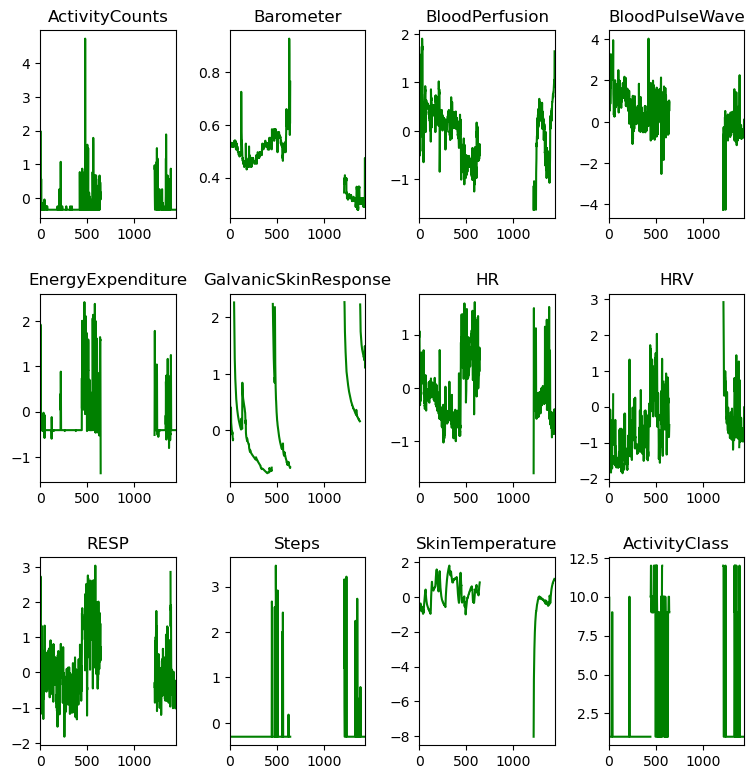

In [14]:
# visualize
plotter(np.random.choice(data.shape[0], 1, replace=False)[0], data)

# Imputation

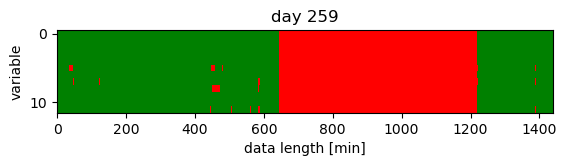

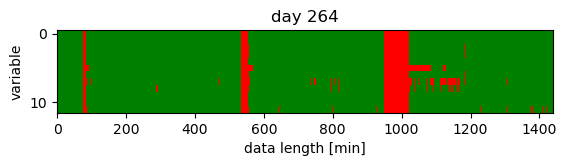

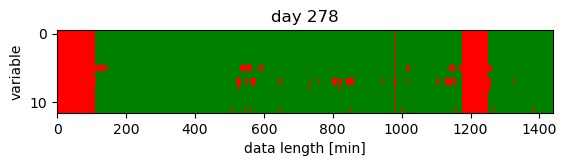

In [15]:
# visualize missing data (red: missing data, green: data)
N = 3
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

In [16]:
# imputation (everything)
MAX_FILL = 1440 # maximum imputation window (from both sides!)
METHOD = 'linear' # imputation method

data_imputed = imputer(data, max_fill=MAX_FILL, method=METHOD)

C:\Users\jjung\AppData\Local\Temp\ipykernel_9328\1122909922.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])


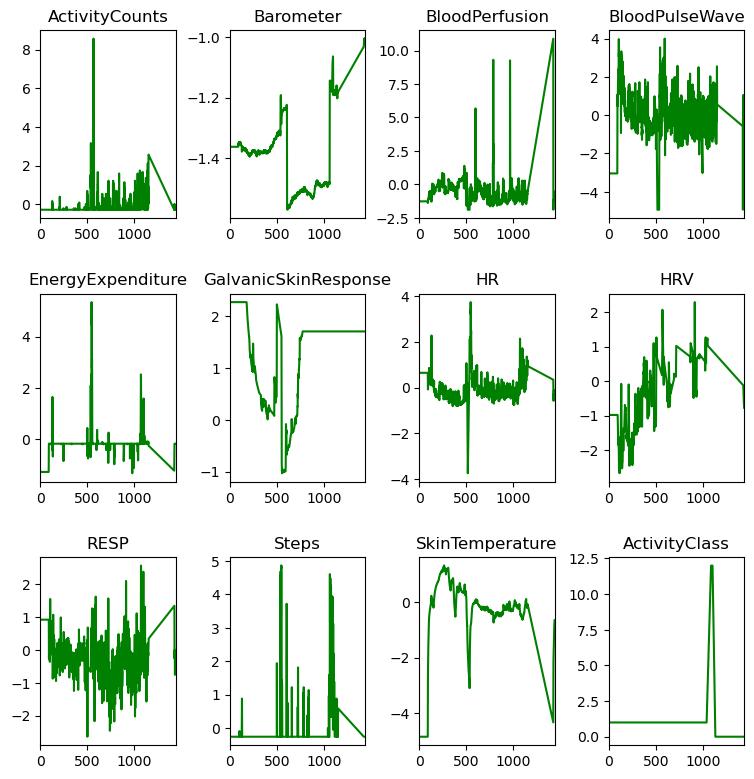

In [17]:
# visualize effect of imputation (red: fatigued, green: vigilant)
plotter(np.random.choice(data_imputed.shape[0], 1, replace=False)[0], data_imputed)

# Build feature vector

TZdiff not needed as additional feature?

In [18]:
query = '''
SELECT subjectID, GROUP_CONCAT(DISTINCT timezone)
FROM data
GROUP BY subjectID
HAVING COUNT(DISTINCT timezone) > 1;'''
sqldf(query)

,subjectID,GROUP_CONCAT(DISTINCT timezone)
0,24,"CET,CEST"
1,26,"CET,CEST"
2,27,"CET,CEST"


Statistical features

In [19]:
X = feature_vector(data_imputed) if USE_IMPUTATION else feature_vector(data)
y = label_vector(data_imputed) if USE_IMPUTATION else label_vector(data)

print(X.shape, y.shape)

(317, 284) (317, 2)


In [20]:
# check no NaNs in feature vector
for i, x in enumerate(X):
    assert np.sum(np.isnan(x)) == 0, f'Found NaN(s) in feature vector for day {i}'
print('All okay!')

All okay!


In [21]:
# metadata
days, _ = data.shape

metadata = []
for day in range(days):
    metadata.append({'date': data['date'].iloc[day], 'subjectID': data['subjectID'].iloc[day]})

# Export data

In [22]:
# file path to data folder
output_path = './Output'

In [23]:
# save all vectors as separate files for data generator (WARNING: takes a lot of time)
with tqdm(total=len(X)) as pbar:
    for i, (x, y_) in enumerate(zip(X, y)):
        np.save(output_path + f'/feature_vector_stat{i}', x)
        np.save(output_path + f'/labels_stat{i}', y_)
        pbar.update(1)

100%|██████████| 317/317 [00:00<00:00, 1053.16it/s]


In [24]:
# save metadata
with open(output_path + '/metadata_stat.txt','w') as dat:
    dat.write(str(metadata))